# 📘 Topic Modeling on Protests Dataset using Top2Vec

This notebook uses **Top2Vec** to perform unsupervised topic modeling on protest descriptions from the **ACLED Iran dataset**. Top2Vec identifies topics by jointly embedding documents and words into a semantic space, allowing for more coherent and context-aware topic discovery.

The workflow includes:
- Cleaning and preprocessing protest text
- Training Top2Vec with various embedding models (e.g., Doc2Vec, Universal Sentence Encoder)
- Extracting and visualizing top keywords for each topic
- Evaluating the results using **topic coherence** and **topic diversity** metrics

This approach highlights nuanced protest themes without the need for extensive preprocessing or pre-defined topic counts, making it suitable for exploratory analysis.


## 📦 Import Libraries

In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from top2vec import Top2Vec
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


2025-04-25 02:16:14.224414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745547374.244733   10511 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745547374.251004   10511 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745547374.267353   10511 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745547374.267370   10511 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745547374.267372   10511 computation_placer.cc:177] computation placer alr

## 📂 Load Data

In [4]:
file_path = r"/home/ubuntu/Capstone_Files/data/ACELD_Iran.csv"
df = pd.read_csv(file_path, sep=';')
print(df.head().to_string())


  event_id_cnty        event_date  year  time_precision   disorder_type event_type    sub_event_type             actor1          assoc_actor_1      inter1 actor2 assoc_actor_2 inter2      interaction civilian_targeting  iso       region country                     admin1         admin2   admin3              location  latitude  longitude  geo_precision                                                                              source             source_scale                                                                                                                                                                                                                                                                                                              notes  fatalities                  tags   timestamp
0      IRN30318  06 February 2025  2025               1  Demonstrations   Protests  Peaceful protest  Protesters (Iran)  Health Workers (Iran)  Protesters    NaN           NaN    NaN  

## 📝 Extract and Filter Protest Texts

In [8]:
texts = df['notes'].dropna().astype(str).tolist()

protest_keywords = set(["protest", "strike", "rally", "demonstration", "march", "boycott", "sit-in", "petition"])
 # Truncated for brevity, full list in code
filtered_texts = [text for text in texts if any(word in text.lower() for word in protest_keywords)]


## 🧹 Preprocess Texts

In [9]:
custom_stopwords = set(stopwords.words('english')).union(protest_keywords)

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = simple_preprocess(text, deacc=True)
    tokens = [word for word in tokens if word not in custom_stopwords and len(word) > 2]
    return " ".join(tokens)

cleaned_texts = [preprocess(text) for text in filtered_texts if preprocess(text) != ""]


## 📏 Define Coherence Scoring

### 📈 C_V Coherence Score: What it is

The **C_V Coherence Score** evaluates how semantically meaningful and internally consistent a topic is. It combines two important dimensions:

- **Co-occurrence Frequency**: How often the top words appear together in the original texts (using a sliding window).
- **Semantic Similarity**: How closely related the top words are in meaning, based on cosine similarity of their word embeddings.

A **higher C_V score** means:
- The topic’s top words frequently occur together in the texts.
- The words are more semantically coherent.

The C_V score leverages **Normalized Pointwise Mutual Information (NPMI)** and cosine similarity to assess topic coherence.

---

### 🧮 Formula (Conceptual)

Let:
- \( W = \{w_1, w_2, \dots, w_k\} \) : the top-k words in a topic
- \( \text{NPMI}(w_i, w_j) \) : the Normalized Pointwise Mutual Information between \( w_i \) and \( w_j \)
- \( \text{Sim}(w_i, w_j) \) : the semantic similarity (e.g., cosine similarity) between word embeddings of \( w_i \) and \( w_j \)

Then the C_V score is computed as an **aggregated combination** of:

$$
\\text{C}_V = \\frac{1}{|W|^2} \\sum_{i,j} \\text{NPMI}(w_i, w_j) \\times \\text{Sim}(w_i, w_j)
$$

> *Note*: Exact implementation may vary depending on the library used (e.g., Gensim), but the conceptual components remain the same.




In [10]:
def calculate_coherence_score(model, texts):
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    topic_words, _, _ = model.get_topics()
    topics = [list(topic) for topic in topic_words]
    coherence_model = CoherenceModel(topics=topics, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()


📊 Topic Diversity (Top2Vec)
What it is:

Topic Diversity measures how distinct the top words are across all discovered topics. A higher score suggests that each topic captures a unique theme, with less repetition of keywords between topics.

For Top2Vec, which automatically identifies the number of topics and generates top keywords per topic based on document embeddings, this metric is useful for evaluating how semantically diverse the topics are.

**Formula:**  

Let \( T \) = number of topics  
Let \( k \) = number of top words per topic  
Let \( W_t \) = set of top‑k words for topic \( t \)

Then, Topic Diversity is calculated as:

$$
\text{Diversity} = \frac{\left|\bigcup_{t=1}^{T} W_t\right|}{T \times k}
$$

A value of 1.0 means all topics have completely unique top words (no overlap), while lower values indicate overlapping or redundant topic terms.


In [25]:
def compute_topic_diversity(topics_words, topk=10):
    """
    Compute topic diversity score for Top2Vec output.
    
    Input:
        topics_words (List[List[str]] or ndarray): List of topic keyword lists
        topk (int): Number of top words per topic to consider
    
    Output:
        float: Topic diversity score (unique words / total words)
    """
    # Ensure words are strings and limit to top-k
    top_words_per_topic = [set(map(str, topic[:topk])) for topic in topics_words]
    
    # Flatten all words
    all_top_words = [word for topic in top_words_per_topic for word in topic]
    unique_words = set(all_top_words)
    
    return len(unique_words) / (len(top_words_per_topic) * topk)


## 🧠 Train Top2Vec Models and Evaluate

2025-04-25 03:53:07,318 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Evaluating model: universal-sentence-encoder


/home/ubuntu/.virtualenvs/Capstone_Project/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-04-25 03:53:08,403 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2025-04-25 03:53:12,058 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-04-25 03:53:16,896 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/home/ubuntu/.virtualenvs/Capstone_Project/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-25 03:53:23,384 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents

Coherence Score for universal-sentence-encoder: 0.4057
Topic Diversity Score for universal-sentence-encoder: 1.0000
------------------------------------------------------------
Evaluating model: doc2vec


2025-04-25 03:53:34,259 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-04-25 04:13:52,139 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/home/ubuntu/.virtualenvs/Capstone_Project/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-25 04:13:56,942 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
/home/ubuntu/.virtualenvs/Capstone_Project/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/.virtualenvs/Capstone_Project/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite

Coherence Score for doc2vec: 0.5476
Topic Diversity Score for doc2vec: 1.0000
------------------------------------------------------------


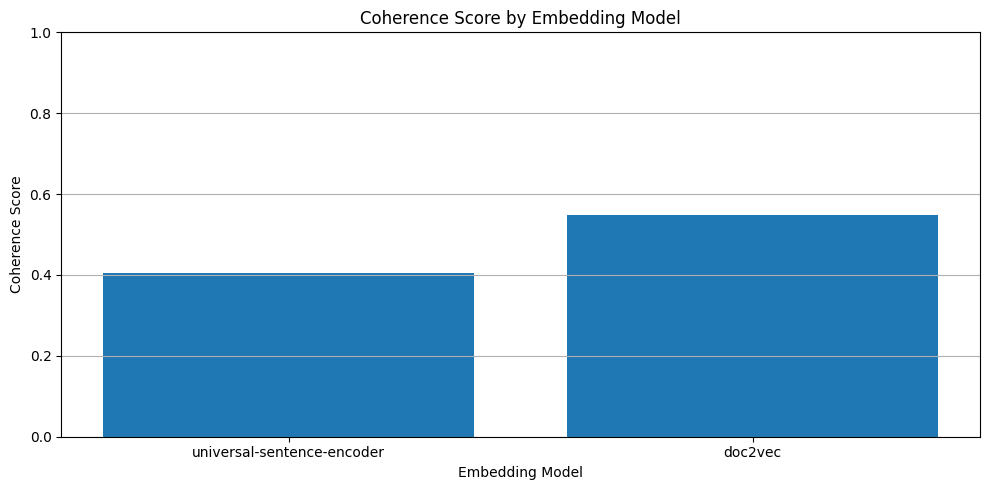

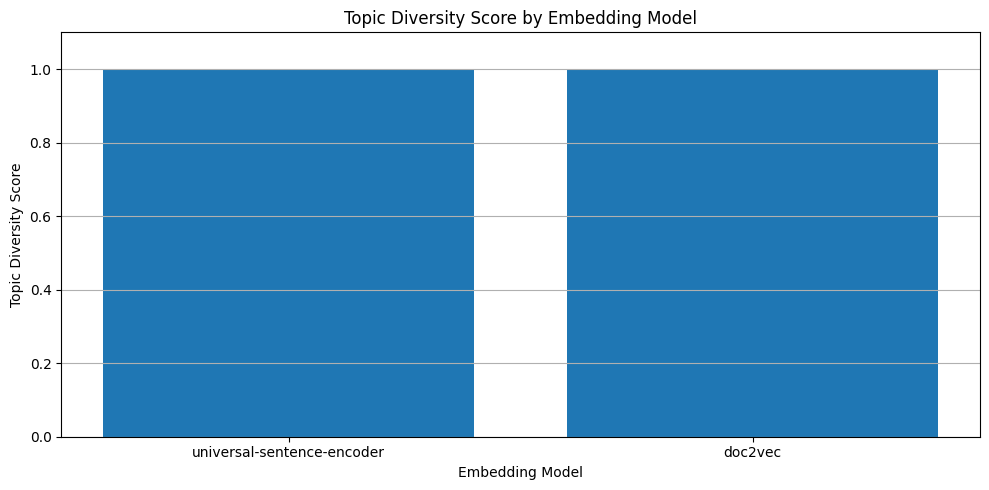

In [29]:
import matplotlib.pyplot as plt

embedding_models = ['universal-sentence-encoder', 'doc2vec']
coherence_scores = []
diversity_scores = []

for model_name in embedding_models:
    print(f"Evaluating model: {model_name}")
    
    # Train Top2Vec model
    model = Top2Vec(
        documents=cleaned_texts,
        embedding_model=model_name,
        speed="deep-learn",
        workers=8
    )

    # Calculate coherence score
    coherence_score = calculate_coherence_score(model, cleaned_texts)
    coherence_scores.append(coherence_score)

    # Calculate topic diversity score
    topic_words = model.get_topics()
    diversity_score = compute_topic_diversity(topic_words, topk=10)
    diversity_scores.append(diversity_score)

    print(f"Coherence Score for {model_name}: {coherence_score:.4f}")
    print(f"Topic Diversity Score for {model_name}: {diversity_score:.4f}")
    print("-" * 60)

# Plotting results
plt.figure(figsize=(10, 5))
plt.bar(embedding_models, coherence_scores)
plt.title("Coherence Score by Embedding Model")
plt.ylabel("Coherence Score")
plt.xlabel("Embedding Model")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(embedding_models, diversity_scores)
plt.title("Topic Diversity Score by Embedding Model")
plt.ylabel("Topic Diversity Score")
plt.xlabel("Embedding Model")
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
